# User Input Clustering

In [1]:
import numpy as np
import pandas as pd
import sentence_transformers as stf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from tqdm.notebook import tqdm

## Importing Data

In [2]:
import regex as re

def has_cyrillic(text):
    return bool(re.search('[а-яА-Я]', text))

In [3]:
data_path = "data/user_review.csv"
raw = pd.read_csv(data_path, delimiter=',')
raw['Review'] = raw['Review'].astype('str')

print("Raw data size: {}".format(raw.shape))

Raw data size: (458433, 2)


In [4]:
raw.Review = raw.Review.map(lambda paraf: paraf.split('.')[0])
raw = raw[(raw.Review.str.len() > 10) & (raw.Review.str.len() < 100) & (raw.Review.map(has_cyrillic))]
data = raw.drop_duplicates(subset=["Review"])[:10000]
print("Data size {}".format(data.shape))
data.head(10)

Data size (10000, 2)


,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд дер...,5
1,"Отключается при температуре близкой к нулю, не...",4
3,Постарался наиболее ёмко и коротко описать все...,4
4,Достойный телефон,5
6,Мой первый айфон,5
8,Долгое время пользовалась iPhone 5s 16Gb,5
11,"Вот уже третий год радует телефон, а с ios10 с...",5
12,Телефонами apple пользуюсь с выхода модели 3G ...,4
13,Аккумулятора в стандартном режиме всегда хвата...,5
14,После 5s чувствуется разница в первую очередь ...,5


## Clustering Algorithm

In [5]:
vec_model = stf.SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

### DBSCAN

Using DBSCAN to calculate initial cluster centers (bootstrap for KMeans)

In [6]:
def dbscan_centers(embeddings, debug=True):
    size = embeddings.shape[0] if embeddings.shape[0] < 1000 else 1000
    distance_matrix = np.zeros((size, size))

    for x in tqdm(range(size), desc="Distance Matrix", total=size, disable=not debug):
        for y in range(x + 1, size):
            dist = np.linalg.norm(embeddings[x] - embeddings[y])
            distance_matrix[x, y] = dist
            distance_matrix[y, x] = dist

    np.fill_diagonal(distance_matrix, np.inf)
    dbscan_eps = np.mean(np.min(distance_matrix, axis=0))
    min_samples = max(2, embeddings.shape[0] // size)
    dbscan_inst = DBSCAN(min_samples = min_samples, eps = dbscan_eps * 1.2, metric = "l2")

    fit_result = dbscan_inst.fit(embeddings)
    labels = fit_result.labels_

    centers = []
    for label in set(labels):
        if label != -1:
            indices = list(filter(lambda i: labels[i] == label, range(len(labels))))
            cur_embeddings = np.array([embeddings[i] for i in indices])
            centers.append(np.mean(cur_embeddings, axis=0))
    centers = np.array(centers)

    return centers

### KMeans

Using KMeans to make clusters based on sentences vectors

In [7]:
def kmeans_clustering(texts, embeddings, init_clusters):
    kmeans = KMeans(n_clusters=init_clusters.shape[0], n_init=1, init=init_clusters)
    fit_result = kmeans.fit(embeddings)

    labels = fit_result.labels_
    centers = fit_result.cluster_centers_

    distances = [np.linalg.norm(centers[label] - embeddings[i]) for i, label in enumerate(labels)]

    cluster_names = {}
    for label in set(labels):
        indices = list(filter(lambda i: labels[i] == label, range(len(labels))))
        label_dist = [distances[i] for i in indices]
        label_texts = [texts[i] for i in indices]
        cluster_names[label] = label_texts[np.argmin(label_dist)]

    return pd.DataFrame.from_dict({
        "text": texts,
        "label": labels,
        "name": list(map(lambda i: cluster_names[i], labels)),
    }), embeddings

### Tying all together

In [8]:
def input_clustering(texts, debug = True):
    if debug:
        print("Transforming sentences")
    embeddings = vec_model.encode(texts, show_progress_bar=debug)
    if debug:
        print("Producing inital clusters")
    init_clusters = dbscan_centers(embeddings, debug)
    if debug:
        print("Clustering vectors")
    return kmeans_clustering(texts, embeddings, init_clusters)

In [9]:
clustered, embeddings = input_clustering(data.Review.array[:1000]) # Will take only 1000 for demonstration

Transforming sentences


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Producing inital clusters


Distance Matrix:   0%|          | 0/1000 [00:00<?, ?it/s]

Clustering vectors


### Representation

Trying to represent results on graph and in text

In [10]:
def graph_vis(clustered, samples = 5):
    to_display = []
    to_label = []
    to_fit = []
    for label in set(clustered.label):
        indices = clustered[clustered.label == label][:samples].index.array
        to_display = to_display + [clustered.text[i][:30] for i in indices]
        to_fit = to_fit + [embeddings[i] for i in indices]
        to_label = to_label + [clustered.label[i] for i in indices]

    pca = PCA(n_components=2, random_state=42)
    reduced = pca.fit_transform(to_fit)

    plt.figure(figsize=(20, 20))
    plt.scatter(reduced[:, 0], reduced[:,1], marker="x", alpha=0.7, c = to_label)
    for i in tqdm(range(len(to_display)), total = len(to_display)):
        plt.text(reduced[i,0], reduced[i,1], to_display[i])
    plt.grid(True)
    plt.show()

def cluster_summary(clustered):
    for label in set(clustered.label):
        print("Label: {} Name: {}".format(label, clustered[clustered.label == label].name.iloc[0]))

Label: 0 Name: Пользуюсь полтора года
Label: 1 Name: Очень долго выбирала замену своему iphone 4s, нужен был больше дисплей и, желательно Android
Label: 2 Name: Аккумулятор слабоват,но его хватает на целый день пользования интернтом
Label: 3 Name: Пожалела о его покупке
Label: 4 Name: вообщем телефон замечательный,особенно за своиденьги
Label: 5 Name: Больше лыжи брать не буду
Label: 6 Name: аппарат сам по себе неплохой
Label: 7 Name: Качественный телефон но от предыдущей версий особо ни чем не отличается
Label: 8 Name: До этого был 5-й айфон
Label: 9 Name: Все устраивает кроме батарейки и полукруглой задней крышки
Label: 10 Name: Тут особо разглагольствовать не буду, скажу только, что аппаратом доволен очень
Label: 11 Name: Купил как дополнительный телефон, т
Label: 12 Name: Очень понравился аппарат, до него был samsung 9305
Label: 13 Name: Попонтоваться можно взять
Label: 14 Name: Отличный аппарат! Пользуюсь LG G2 6й месяц
Label: 15 Name: Выбирал между samsung galaxy note 3 и LG G2
L

  0%|          | 0/40 [00:00<?, ?it/s]

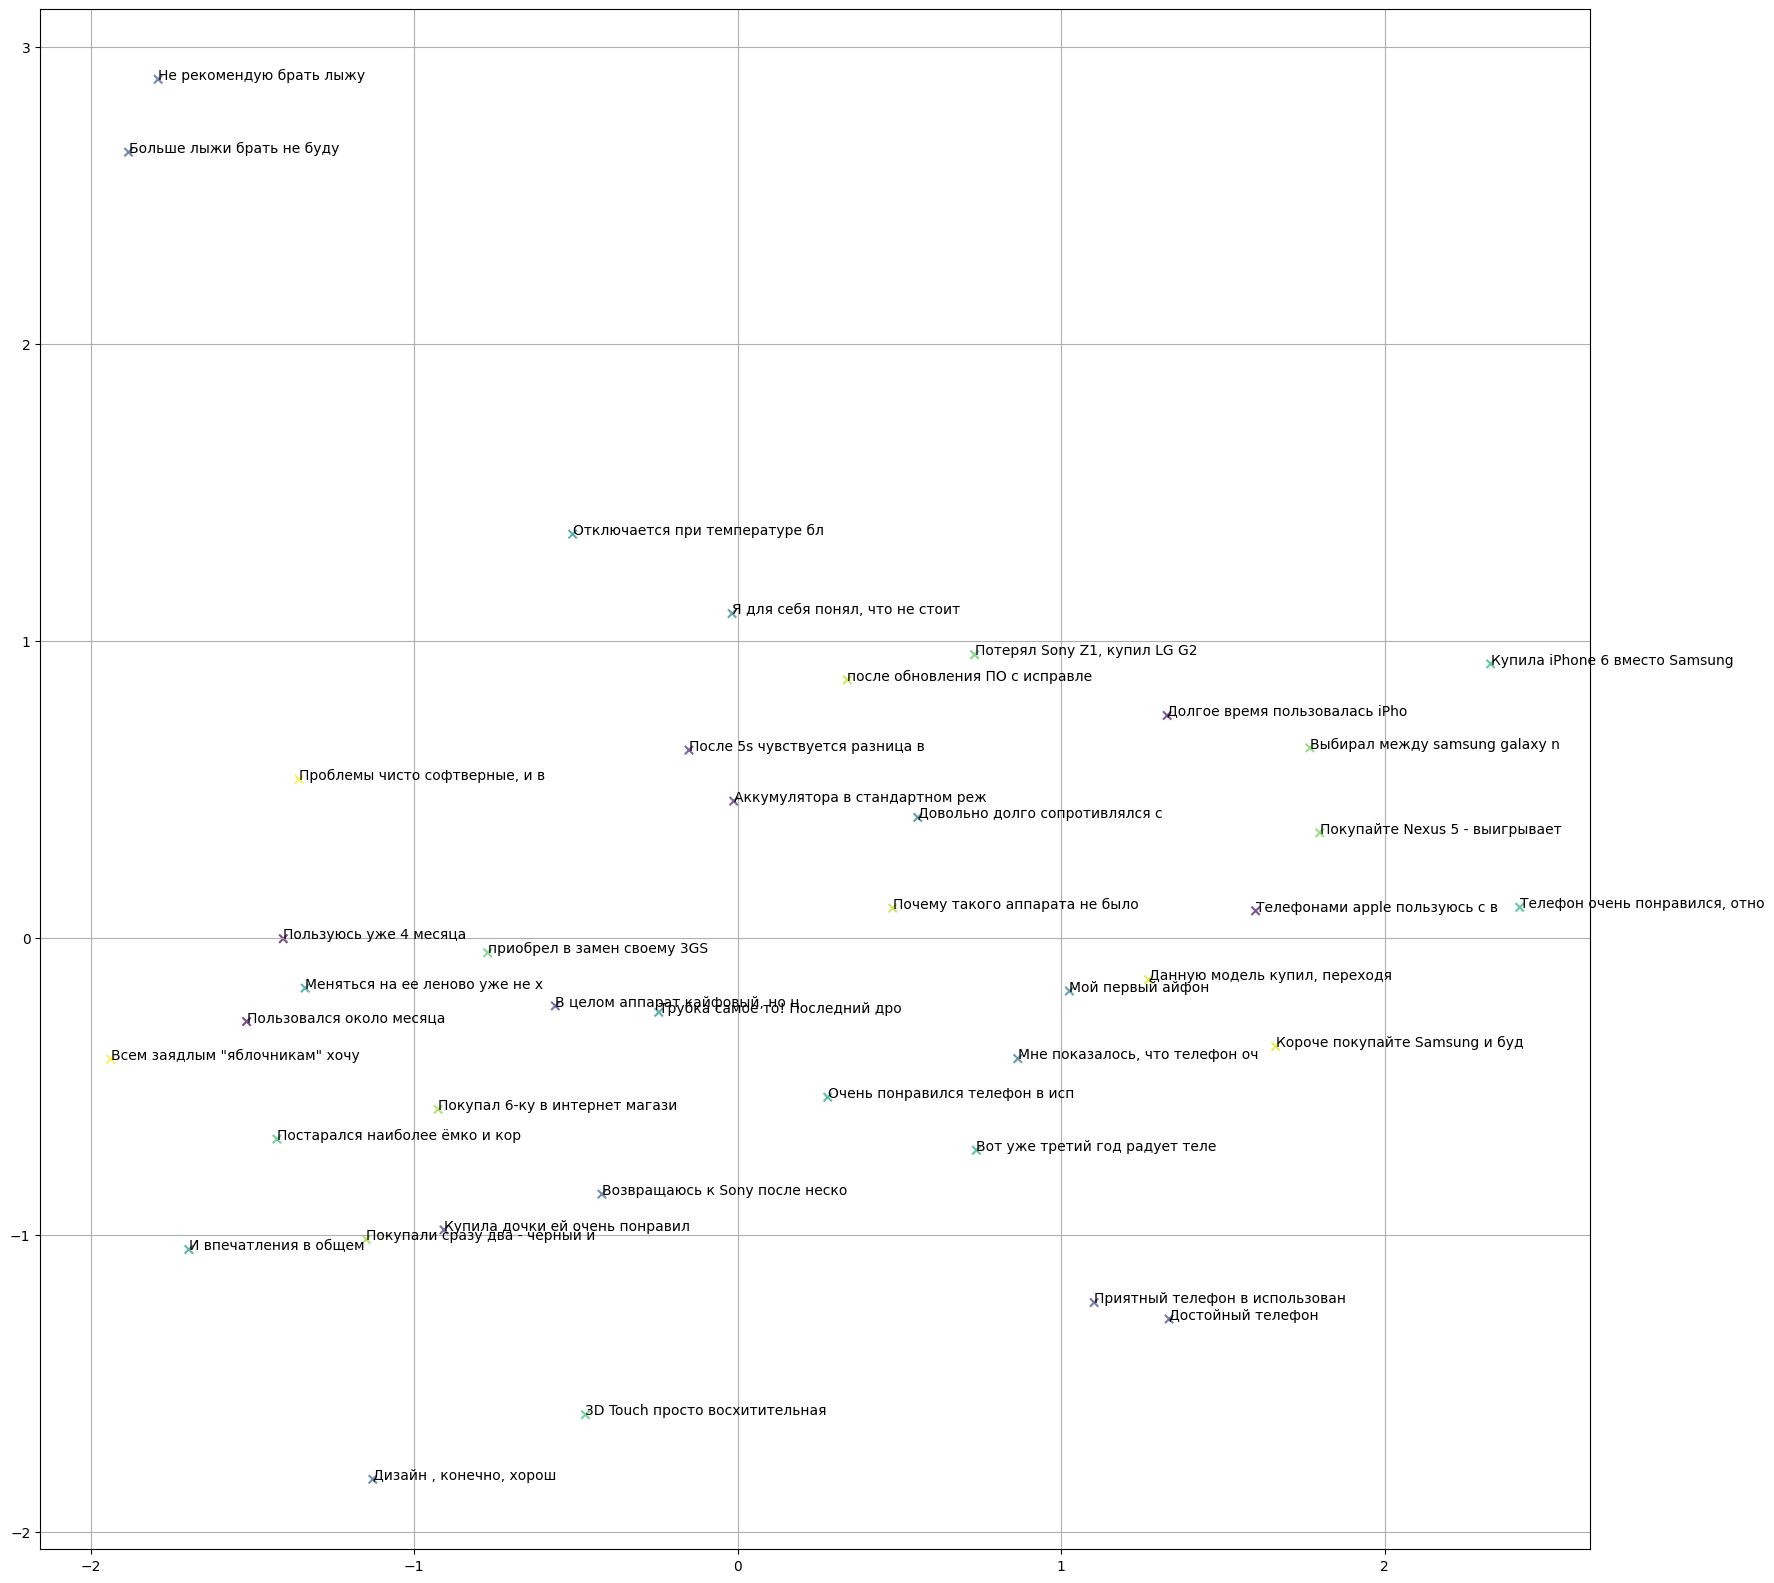

In [11]:
cluster_summary(clustered)

graph_vis(clustered, samples = 2)

In [ ]:
### Thats it!